# A Differentiable Gain Control

In the following, we'll use the PyTorch features we just covered to implement our first differentiable digital signal processor. We will take a pair of dry and processed audio, and we will use gradient descent to estimate the parameters that were applied to the dry signal to obtain the processed one.

We will start off with a very simple signal processing operation: a gain control. Later in this tutorial, we will see how these concepts can be applied to estimate control parameters of more complex processing chains. As we saw in the previous section, we can inherit use the `Module` and `Parameter` classes from PyTorch to define the behavior and parameters of our gain control:

In [1]:
import torch

class LinearGain(torch.nn.Module):
    def __init__(self, gain=1.0):
        super().__init__()
        self.gain = torch.nn.Parameter(torch.tensor(gain))

    def forward(self, x):
        return self.gain * x


For our audio example, we'll use a simple sine wave, and apply some gain to it to obtain the processed signal.

In [2]:
import IPython.display as ipd
from matplotlib import pyplot as plt

sr = 16000
freq = 300

# generate half a second of sine wave at 300 Hz
orig_audio = torch.sin(torch.linspace(0, 2 * torch.pi * freq, sr // 2))

true_gain = 0.15
target_audio = true_gain * orig_audio


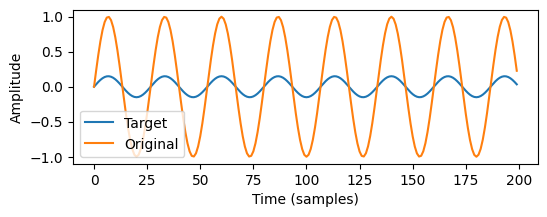

Original signal


Target signal


In [3]:
plt.figure(figsize=(6, 2))
plt.plot(target_audio[:200])
plt.plot(orig_audio[:200])
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend(["Target", "Original"])
plt.show()

print("Original signal")
ipd.display(ipd.Audio(orig_audio, rate=sr, normalize=False))

print("Target signal")
ipd.display(ipd.Audio(target_audio, rate=sr, normalize=False))


Now we can use our differentiable gain control to estimate the applied gain using gradient descent. The following code block should look pretty familiar by now:

In [4]:
diff_gain = LinearGain()

l1_loss = torch.nn.L1Loss()

optim = torch.optim.SGD(diff_gain.parameters(), lr=0.01)

n_iter = 300

gains = []

for i in range(n_iter):
    gains.append(diff_gain.gain.item())
    
    optim.zero_grad()
    estim_audio = diff_gain(orig_audio)
    loss = l1_loss(estim_audio, target_audio)
    loss.backward()
    optim.step()


In [5]:
# Animate the fitting process

import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def get_gain_animation(org, tgt, gains):
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(tgt[:200])
    line,  = ax.plot([], [])
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Amplitude")
    ax.set_ylim(-1, 1)
    ax.legend(["Target", "Estimate"], loc=1)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(np.arange(200), org[:200] * gains[i * 5])
        ax.set_title(f"Estimated signal after {i * 5} iterations")
        return line,

    # Create the animation
    anim = FuncAnimation(fig, animate, init_func=init, frames=len(gains) // 5, interval=50, blit=True)
    plt.close(fig)
    return anim
    
display(HTML(get_gain_animation(orig_audio, target_audio, gains).to_html5_video()))

Looks like we've converged on the correct gain value! However, we've made our task a bit easy for ourselves. What if the signal we're trying to match differs from the processed signal in more ways than just the gain? If we phase shift the target signal by 180 degrees, our estimator suddenly runs into trouble:

In [6]:
shifted_target_audio = true_gain * torch.cos(torch.linspace(0, 2 * torch.pi * freq, sr // 2))

In [7]:
diff_gain = LinearGain()

l1_loss = torch.nn.L1Loss()

optim = torch.optim.SGD(diff_gain.parameters(), lr=0.01)

n_iter = 300

gains = []

for i in range(n_iter):
    gains.append(diff_gain.gain.item())
    
    optim.zero_grad()
    estim_audio = diff_gain(orig_audio)
    loss = l1_loss(estim_audio, shifted_target_audio)
    loss.backward()
    optim.step()

display(HTML(get_gain_animation(orig_audio, shifted_target_audio, gains).to_html5_video()))


What's going on here? Although this phase shift changes nothing about the human perception of the sound, it appears that the loss function we used to compare the signals no longer delivers gradients that point us into the correct direction. Let's take a look at the behavior of the loss function as the gain changes:

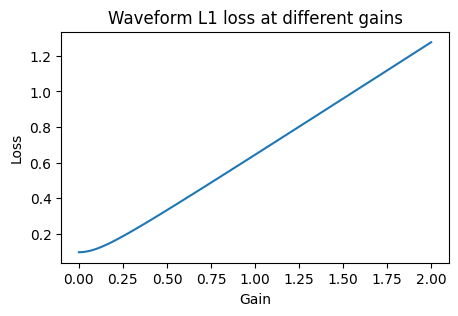

In [8]:
gain_vals = torch.linspace(0.0, 2.0, 100)
losses = (gain_vals.unsqueeze(1) * orig_audio - shifted_target_audio).abs().mean(dim=1)

plt.figure(figsize=(5, 3))
plt.title("Waveform L1 loss at different gains")
plt.plot(gain_vals, losses)
plt.xlabel("Gain")
plt.ylabel("Loss")
plt.show()

There is no minimum in sight at the true gain value of 0.15; instead, descending down the gradient of the loss functions leads us right down to zero gain.

The correct choice of the loss function can play a crucial role in optimizing parameters for audio controls. In this case, we want the loss to be invariant to phase shifts. In the case of gain, we could look at the total energy of the signals, but that loses a lot of information that we might want to preserve for more complex controls. Instead, we could compute the spectrogram and compare the magnitudes of the frequency bins. We can write a custom loss module to do just that:

In [9]:
class SpectralLoss(torch.nn.Module):
    def __init__(self, power=1):
        super().__init__()
        self.power = power

    def forward(self, x, y):
        x_mags = torch.fft.rfft(x).abs() ** self.power
        y_mags = torch.fft.rfft(y).abs() ** self.power
        
        return torch.nn.functional.l1_loss(x_mags, y_mags)

Let's take a look at the behavior of this loss function:

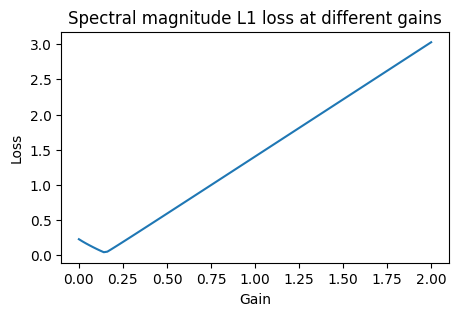

In [10]:

losses = (torch.fft.rfft(gain_vals.unsqueeze(1) * orig_audio, dim=1).abs() - torch.fft.rfft(shifted_target_audio).abs()).abs().mean(dim=1)

plt.figure(figsize=(5, 3))
plt.title("Spectral magnitude L1 loss at different gains")
plt.plot(gain_vals, losses)
plt.xlabel("Gain")
plt.ylabel("Loss")
plt.show()

Looks like there's a clear global minimum at the correct place now! We'd now expect our estimator to converge on the correct gain value again: Let's try it out:

In [11]:
diff_gain = LinearGain()

spectral_loss = SpectralLoss()

optim = torch.optim.SGD(diff_gain.parameters(), lr=0.01)

n_iter = 300

gains = []

for i in range(n_iter):
    gains.append(diff_gain.gain.item())
    
    optim.zero_grad()
    estim_audio = diff_gain(orig_audio)
    loss = spectral_loss(estim_audio, shifted_target_audio)
    loss.backward()
    optim.step()

display(HTML(get_gain_animation(orig_audio, shifted_target_audio, gains).to_html5_video()))

 The [`auraloss`](https://github.com/csteinmetz1/auraloss) package contains many more loss functions that are useful for audio applications. We're now ready to move on to more complex signal processors. In the next section, we'll look at synthesizers.